In [1]:
import pandas as pd
import os
import numpy as np
from keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf
from tensorflow.keras import layers


2024-12-08 01:52:56.163551: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class DataPreprocess:
    def __init__(self):
        pass

    def load_data(self, path):
        df = pd.read_csv(path)
        df.drop("Unnamed: 0", inplace=True, axis = 1)
        return df

    def get_bid_levels(self, df, bid_levels):
        df_tmp = pd.DataFrame()
        df_tmp['time'] = pd.to_datetime(df['system_time'])
        df_tmp['midpoint'] = df['midpoint']
        
        # Filter ask and bid volume columns
        ask_cols = [f'asks_limit_notional_{i}' for i in range(bid_levels)]
        bid_cols = [f'bids_limit_notional_{i}' for i in range(bid_levels)]
        ask_cols = [col for col in ask_cols if col in df.columns]
        bid_cols = [col for col in bid_cols if col in df.columns]
        
        # Assign ask and bid volumes
        for lvls in range(len(ask_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_volume{lvls}'] = df[ask_cols[lvls]]
        for lvls in range(len(bid_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_volume{lvls}'] = df[bid_cols[lvls]]
        
        # Filter ask and bid distance columns
        ask_distance_cols = [f'asks_distance_{i}' for i in range(bid_levels)]
        bid_distance_cols = [f'bids_distance_{i}' for i in range(bid_levels)]
        ask_distance_cols = [col for col in ask_distance_cols if col in df.columns]
        bid_distance_cols = [col for col in bid_distance_cols if col in df.columns]
        
        # Assign ask and bid prices
        for lvls in range(len(ask_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[ask_distance_cols[lvls]])
        for lvls in range(len(bid_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[bid_distance_cols[lvls]])
        return df_tmp

    """
        For a actively traded stock,
        1. If there is an increase in the bid price in future compared to its current or previous value.
            We take the Bid volume.
        2. If the previous and current price is same we take the difference in the volume.
        3. If the current price is less than the current one then we take -ve of the current volume.

        Order Flow Imbalance is actually a factor that denotes the buying side or selling pressue for a particular stock at that level.
        When OFI > 0 it means that market is dominated by sellers. Lot more bids have happened.
        When OFI < 0 it means that market is dominated by buyers. Lot more asks have happened.
    """
    def get_bid_with_ofi_levels(self, df_tmp, bid_levels):
        for lvls in range(bid_levels):
            bid_price = df_tmp[f'bid_price{lvls}']
            ask_price = df_tmp[f'ask_price{lvls}']
            bid_volume = df_tmp[f'bid_volume{lvls}']
            ask_volume = df_tmp[f'ask_volume{lvls}']
            
            # Shift prices and volumes to compute differences
            bid_price_prev = bid_price.shift(1)
            ask_price_prev = ask_price.shift(1)
            bid_volume_prev = bid_volume.shift(1)
            ask_volume_prev = ask_volume.shift(1)
            
            # Calculate bid and ask order flows
            bid_of = np.where(
                bid_price > bid_price_prev, bid_volume,
                np.where(bid_price == bid_price_prev, bid_volume - bid_volume_prev, -bid_volume)
            )
            ask_of = np.where(
                ask_price > ask_price_prev, -ask_volume,
                np.where(ask_price == ask_price_prev, ask_volume - ask_volume_prev, ask_volume)
            )
            
            # Calculate OFI
            df_tmp[f'ofi_level{lvls}'] = bid_of - ask_of
        return df_tmp

    
    def make_window(self, window_size, dataframe, partition):
        normalized_df = df_new.to_numpy()
        dataframe.drop("time", inplace=True, axis = 1)
        train_length = int(len(normalized_df) * partition)
        data_length = len(normalized_df)
        
        midpoint_idx = df_new.columns.get_loc("midpoint")
        
        windows_train = timeseries_dataset_from_array(
            normalized_df[:train_length],  # Features for training
            normalized_df[window_size:train_length + window_size, midpoint_idx],  # Labels for training
            window_size,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=64,
            shuffle=False,
            seed=None
        )
        
        # Windows for test dataset
        windows_test = timeseries_dataset_from_array(
            normalized_df[train_length:data_length - window_size],  # Features for testing
            normalized_df[train_length + window_size:, midpoint_idx],  # Labels for testing
            window_size,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=64,
            shuffle=False
        )
        return windows_train, windows_test

    """
        Returns x_train, y_train, x_test, y_test
    """
    def make_generic_window(self, window_size, df, partition, make_window=False):
        feature_columns = [col for col in df.columns if col != 'midpoint' and col != 'time']
        X, y = [], []

        if make_window:
            # Create sliding windows
            for i in range(len(df) - window_size):
                X.append(df.iloc[i:i + window_size][feature_columns].values)
                y.append(df.iloc[i + window_size]['midpoint'])
            
            X = np.array(X)
            y = np.array(y)
            split_point = int(len(df)*partition)
            X_train = X[:split_point]
            X_test = X[split_point:]
            y_train = df.iloc[:split_point]['midpoint']
            y_test =  df.iloc[split_point:]['midpoint']
            return X_train, X_test, y_train, y_test
        else:
            split_point = int(len(df)*partition)
            X_train = X[:split_point]
            X_test = X[split_point:]
            y_train = df.iloc[:split_point]['midpoint']
            y_test =  df.iloc[split_point:]['midpoint']
            
            return X_train, X_test, y_train, y_test

    def normalize_data(self, df2, train_length):
        """
        Normalizes data based on the training dataset mean and std.
        """
        if "time" in df2.columns:
            df2 = df2.drop(columns=["time"])
        mean_df = df2[:train_length].mean()
        std_df = df2[:train_length].std()
        normalized_df = (df2 - mean_df) / std_df
        return normalized_df

    # Function to extract data from TensorFlow Dataset
    def extract_data_from_dataset(self, dataset):
        X_list = []
        y_list = []
        for X_batch, y_batch in dataset:
            X_list.append(X_batch.numpy())
            y_list.append(y_batch.numpy())
        X_array = np.vstack(X_list)  # Combine batches into one array
        y_array = np.concatenate(y_list)
        return X_array, y_array

    def r_get_window(self, df_tmp, train_length, window_size):
        # Drop time column (not needed for input features)
        if "time" in df_tmp.columns:
            df_tmp = df_tmp.drop(columns=["time"])
        
        # Split dataset into train and test sets
        data_length = df_tmp.shape[0]
        train_length = round(0.8 * data_length)  # 80% training data

        self.train_length = train_length
        
        normalized_df = dp.normalize_data(df_tmp, train_length)

        data_array = normalized_df.to_numpy()
        
        X = data_array[:, 1:]  # All columns except the first ('midpoint')
        y = data_array[:, 0]#df_tmp["midpoint"]
        #y = data_array[:, 0]   # The first column is 'midpoint'
        
        windows_train = timeseries_dataset_from_array(
            X[:train_length],                    # Features for training
            y[window_size:(train_length+window_size)],  # Target (midpoint) for training
            sequence_length=window_size,        # Length of each input sequence
            sequence_stride=1,                  # Step size for creating sequences
            sampling_rate=1,                    # Sample every time step
            batch_size=64,                      # Batch size
            shuffle=True                        # Shuffle training data
        )
        
        # Windows for test dataset
        windows_test = timeseries_dataset_from_array(
            X[train_length:(data_length-window_size)],  # Features for testing
            y[train_length + window_size:],            # Target (midpoint) for testing
            sequence_length=window_size,               # Length of each input sequence
            sequence_stride=1,                         # Step size for creating sequences
            sampling_rate=1,                           # Sample every time step
            batch_size=64,                             # Batch size
            shuffle=False                              # Do not shuffle test data
        )
        
        return windows_train, windows_test

    # Function to extract data from TensorFlow Dataset
    def extract_data_from_dataset(self, dataset):
        X_list = []
        y_list = []
        for X_batch, y_batch in dataset:
            X_list.append(X_batch.numpy())
            y_list.append(y_batch.numpy())
        X_array = np.vstack(X_list)  # Combine batches into one array
        y_array = np.concatenate(y_list)
        return X_array, y_array

    def plot_graph(self, y_test, y_pred):
        # Plotting the graphs
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label="Actual", color="blue")
        plt.plot(y_pred, label="Predicted", color="red", linestyle="--")
        plt.legend()
        plt.title("Actual vs Predicted Values")
        plt.xlabel("Sample Index")
        plt.ylabel("Target Value")
        plt.show()

    def get_metrics(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"Mean Squared Error: {mse}")
        print(f"R² Score: {r2}")
        
        dp.plot_graph(y_test, y_pred)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, RepeatVector, LSTM, Dropout
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

def get_model(no_of_levels, window_size):
    """
        early_stop = EarlyStopping(monitor="loss", mode="min", patience=7)
        modelh = Sequential()
        modelh.add(LSTM(units=100, return_sequences=True, activation='relu', input_shape=(window_size, no_of_levels)))
        modelh.add(Dropout(0.2))
        #modelh.add(LSTM(units=100, return_sequences=True, activation='relu'))
        #modelh.add(Dropout(0.2))
        #modelh.add(LSTM(units=100, return_sequences=True, activation='relu'))
        modelh.add(LSTM(units=100, return_sequences=False, activation='relu'))  # No sequences returned here
        modelh.add(Dense(50, activation='relu'))
        modelh.add(Dense(1))  # Final output for regression
        return modelh
    """
    early_stop = EarlyStopping(monitor="loss", mode="min", patience=7)
    modelh = Sequential()
    modelh.add(LSTM(units=100, return_sequences=True, activation='relu', input_shape=(window_size, no_of_levels)))
    modelh.add(Dropout(0.2))
    modelh.add(LSTM(units=100, return_sequences=True, activation='relu'))
    modelh.add(Dropout(0.2))
    #modelh.add(LSTM(units=100, return_sequences=True, activation='relu'))
    modelh.add(LSTM(units=50, return_sequences=False, activation='relu'))  # No sequences returned here
    modelh.add(Dense(20, activation='relu'))
    modelh.add(Dense(1))  # Final output for regression
    return modelh

In [4]:

# Set window size
window_size = 100
num_levels = 10
is_ofi = False


dp = DataPreprocess()

df = dp.load_data("archive/ETH_1min.csv")

df = dp.get_bid_levels(df, num_levels)

data_length = df.shape[0]
train_length = round(0.8 * data_length)

windows_train, windows_test = dp.r_get_window(df, train_length, window_size)

nm_lvl = len(df.columns) - 2

model = get_model(40, window_size)

model.compile(loss="mse", optimizer="adam", metrics=["mse"])
#history = model.fit(windows_train, epochs=10,verbose=1)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


def calculate_metrics_and_plot(model, train_length, lvl):
    # Step 1: Create an instance of the DataPreprocess class
    data_preprocessor = DataPreprocess()
    
    # Step 2: Load the CSV file
    file_path = "archive/ETH_1min.csv"  # Path to the CSV file
    df2 = data_preprocessor.load_data(file_path)
    
    # Step 3: Process the data for 10 bid/ask levels
    eth_df = data_preprocessor.get_bid_levels(df2, bid_levels=lvl)
    eth_df.drop("time", inplace = True, axis = 1)
    eth_df.head()
    
    mean_df = eth_df[:train_length].mean()
    std_df = eth_df[:train_length].std()
    
    normalized_df = (eth_df - mean_df) / std_df
    # Predict
    y_pred = model.predict(windows_test)
    
    # Remove standardization from predictions
    real_pred = y_pred.flatten() * std_df["midpoint"] + mean_df["midpoint"]
    
    # Prepare true values for comparison
    input_pred = eth_df["midpoint"][train_length + window_size:].reset_index(drop=True)
    
    # Align lengths
    min_length = min(len(input_pred), len(real_pred))
    real_pred = real_pred[:min_length]
    input_pred = input_pred[:min_length]
    
    # Calculate metrics
    mse = mean_squared_error(input_pred, real_pred)
    r2 = r2_score(input_pred, real_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R² Score: {r2}")
    
    # Plot
    plt.plot(real_pred, label="Prediction")
    plt.plot(input_pred, label="True Price")
    plt.legend(loc="upper right")
    plt.show()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 100)       │        56,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,041 (656.41 KB)

 Trainable params: 168,041 (656.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 56s 238ms/step - loss: 570672.9375 - mae: 21.5081 - val_loss: 0.7809 - val_mae: 0.7032
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 225ms/step - loss: 0.7367 - mae: 0.7184 - val_loss: 0.5189 - val_mae: 0.5557
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 47s 222ms/step - loss: 0.2892 - mae: 0.3657 - val_loss: 0.1777 - val_mae: 0.3297
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step - loss: 0.0978 - mae: 0.2057 - val_loss: 0.0538 - val_mae: 0.1706
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 51s 237ms/step - loss: 0.0434 - mae: 0.1362 - val_loss: 0.0305 - val_mae: 0.1261
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 47s 222ms/step - loss: 0.0281 - mae: 0.1136 - val_loss: 0.0226 - val_mae: 0.1042
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 49s 229ms/step - loss: 0.0192 - mae: 0.0981 - val_loss: 0.0200 - val_mae: 0.0980
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 227ms/step - loss: 0.0142 - mae: 0.0869 - val_loss: 0.0198 - val_mae: 0.1013
Epoch 9/10
213/213 ━━━━━━━

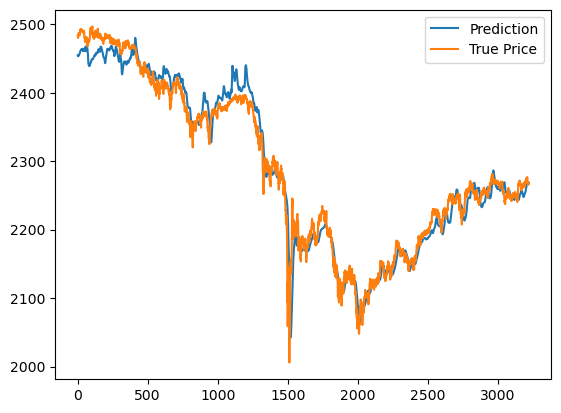

In [6]:

window_size = 100
num_levels = [10]

for lvl in num_levels:
    dp = DataPreprocess()
    
    df = dp.load_data("archive/ETH_1min.csv")
    
    df = dp.get_bid_levels(df, lvl)
    
    data_length = df.shape[0]
    train_length = round(0.8 * data_length)
    
    windows_train, windows_test = dp.r_get_window(df, train_length, window_size)
    
    nm_lvl = len(df.columns) - 2
    
    model2 = get_model(nm_lvl, window_size)
    
    # Compile the model
    model2.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    
    # Model Summary
    model2.summary()
    
    history = model2.fit(
        windows_train,
        validation_data=windows_test,
        epochs=10,
        batch_size=64,
        verbose=1
    )

    calculate_metrics_and_plot(model2, train_length, lvl)

In [7]:
#calculate_metrics_and_plot(model, train_length, 10)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 100, 100)       │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,041 (625.16 KB)

 Trainable params: 160,041 (625.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 58s 241ms/step - loss: 0.1340 - mae: 0.1924 - val_loss: 0.0101 - val_mae: 0.0711
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 54s 252ms/step - loss: 0.0038 - mae: 0.0459 - val_loss: 0.0098 - val_mae: 0.0712
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 225ms/step - loss: 0.0031 - mae: 0.0406 - val_loss: 0.0099 - val_mae: 0.0717
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 51s 241ms/step - loss: 0.0027 - mae: 0.0383 - val_loss: 0.0121 - val_mae: 0.0807
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - loss: 0.0025 - mae: 0.0368 - val_loss: 0.0116 - val_mae: 0.0792
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 47s 220ms/step - loss: 0.0031 - mae: 0.0401 - val_loss: 0.0133 - val_mae: 0.0845
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 47s 222ms/step - loss: 0.0022 - mae: 0.0345 - val_loss: 0.0119 - val_mae: 0.0802
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step - loss: 0.0021 - mae: 0.0341 - val_loss: 0.0180 - val_mae: 0.1015
Epoch 9/10
213/213 ━━━━━━━━━━━━━

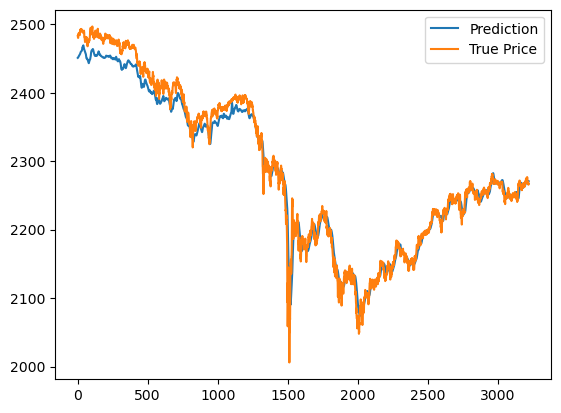

In [20]:

window_size = 100
num_levels = [5]

for lvl in num_levels:
    dp = DataPreprocess()
    
    df = dp.load_data("archive/ETH_1min.csv")
    
    df = dp.get_bid_levels(df, lvl)
    
    data_length = df.shape[0]
    train_length = round(0.8 * data_length)
    
    windows_train, windows_test = dp.r_get_window(df, train_length, window_size)
    
    nm_lvl = len(df.columns) - 2
    
    model2 = get_model(nm_lvl, window_size)
    
    # Compile the model
    model2.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    
    # Model Summary
    model2.summary()
    
    history = model2.fit(
        windows_train,
        validation_data=windows_test,
        epochs=10,
        batch_size=64,
        verbose=1
    )

    calculate_metrics_and_plot(model2, train_length, lvl)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 100, 100)       │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,841 (612.66 KB)

 Trainable params: 156,841 (612.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 53s 223ms/step - loss: 0.1113 - mae: 0.1798 - val_loss: 0.0080 - val_mae: 0.0561
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 226ms/step - loss: 0.0039 - mae: 0.0463 - val_loss: 0.0085 - val_mae: 0.0624
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 226ms/step - loss: 0.0033 - mae: 0.0425 - val_loss: 0.0100 - val_mae: 0.0705
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 47s 219ms/step - loss: 0.0032 - mae: 0.0416 - val_loss: 0.0118 - val_mae: 0.0779
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 226ms/step - loss: 0.0028 - mae: 0.0391 - val_loss: 0.0119 - val_mae: 0.0796
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step
Mean Squared Error: 296.0830030436423
R² Score: 0.9790289168004741


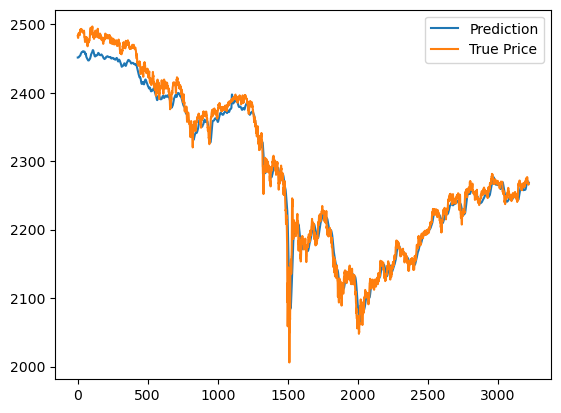

In [26]:

window_size = 100
num_levels = [3]

for lvl in num_levels:
    dp = DataPreprocess()
    
    df = dp.load_data("archive/ETH_1min.csv")
    
    df = dp.get_bid_levels(df, lvl)
    
    data_length = df.shape[0]
    train_length = round(0.8 * data_length)
    
    windows_train, windows_test = dp.r_get_window(df, train_length, window_size)
    
    nm_lvl = len(df.columns) - 2
    
    model2 = get_model(nm_lvl, window_size)
    
    # Compile the model
    model2.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    
    # Model Summary
    model2.summary()
    
    history = model2.fit(
        windows_train,
        validation_data=windows_test,
        epochs=5,
        batch_size=64,
        verbose=1
    )

    calculate_metrics_and_plot(model2, train_length, lvl)